In [20]:
import astroquery

import sympy
from sympy import Symbol, nsolve, solve

from astropy.coordinates import Angle
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import pandas as pd
from astroquery.ned import Ned
from bs4 import BeautifulSoup

import requests

import matplotlib.pyplot as plt

%matplotlib inline

## Download data

In [112]:
Im_url = 'https://ned.ipac.caltech.edu/cgi-bin/OBJatt?delimiter=bar&nondb=row_count&crosid=objname&position=ra%2Cdec&enotes=objnote&position=pretype&position=z&position=zflag&attdat_CON=M&attdat_CON=S&attdat=attned&M=1149&page={:d}'
Sdm_url = 'https://ned.ipac.caltech.edu/cgi-bin/OBJatt?delimiter=bar&nondb=row_count&crosid=objname&position=ra%2Cdec&enotes=objnote&position=pretype&position=z&position=zflag&attdat_CON=M&attdat_CON=S&attdat=attned&M=2368&page={:d}'
Sm_url = 'https://ned.ipac.caltech.edu/cgi-bin/OBJatt?delimiter=bar&nondb=row_count&crosid=objname&position=ra%2Cdec&enotes=objnote&position=pretype&position=z&position=zflag&attdat_CON=M&attdat_CON=S&attdat=attned&M=2374&page={:d}'

In [113]:
info = {'Im': {'url': Im_url, 'pages': 12}, 'Sdm': {'url': Sdm_url, 'pages': 11}, 'Sm': {'url': Sm_url, 'pages': 9}}

In [121]:
for type_name in info.keys():
    type_info = info[type_name]
    pages = []
    for pagenum in range(1, type_info['pages']+1):
        r = requests.get(type_info['url'].format(pagenum))
        content = r.content
        soup = BeautifulSoup(content, 'lxml')
        # now grab the first link
        first_link = soup.find('pre').find('a')
        text = '1  '
        rows = []
        row = []
        # and all the rows
        for element in first_link.next_elements:
            if (element.name == 'a' and
                element.attrs['href'].startswith('/cgi-bin/objsearch?') and
                element.text != text):
                rows.append(row)
                row = []
                text = element.text
            elif element.name == 'h4':
                break  # break when we see the h4 tag that appears after the table
            else:
                row.append(element)
        else:  # no break
            raise RunTimeError

        rows.append(row)  # append last row

        pages.append(rows)  # and add this table to our pages list
        type_info['pages'] = pages

In [193]:
names = []
ras = []
decs = []
obj_types = []
redshifts = []
hrefs = []
gal_types = []

for page in pages:
    for col in page:
        if len(col) < 3:
            continue
        if col[2].name == 'span':
            col_num = col[0]
            details = col[6]
            link = col[7]
            _, name, ra, dec, obj_type, redshift, _, _ = details.split('|')
        else:
            col_num, details, link = col[:3]
            _, _, name, ra, dec, obj_type, redshift, _, _ = details.split('|')
        
        href = link.attrs['href']
        gal_type = link.text
        
        names.append(name)
        ras.append(Angle(ra))
        decs.append(Angle(dec))
        obj_types.append(obj_type)
        redshifts.append(redshift)
        hrefs.append(href)
        gal_types.append(gal_type)

ned_data = pd.DataFrame({'name': names, 'ra': ras, 'dec': decs, 'obj_type': obj_types,
                         'redshift': redshifts, 'href': hrefs, 'gal_type': gal_types})

In [275]:
ned_data.to_csv('/Users/spardy/Research/data/ned_magellanics.csv')

## Reload from disk

In [2]:
ned_data = pd.read_csv('/Users/spardy/Research/data/ned_magellanics.csv')

In [3]:
alfalfa_df = pd.read_csv('/Users/spardy/Research/data/a70_160624.csv')

## Analysis

In [4]:
ned_c = SkyCoord(ned_data['ra'], ned_data['dec'])
alfalfa_c = SkyCoord(alfalfa_df['OCra']*u.degree, alfalfa_df['OCdec']*u.degree)

In [5]:
idx, d2d, d3d = alfalfa_c.match_to_catalog_sky(ned_c)
alfalfa_matches, = np.where(d2d < Angle('2 arcsec'))
ned_matches = idx[alfalfa_matches]

In [6]:
len(ned_matches)

58

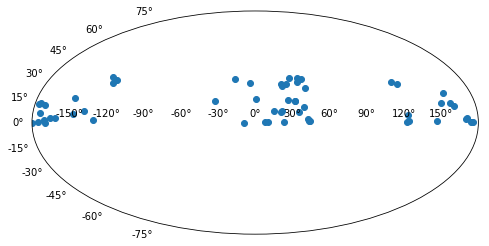

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ned_c[ned_matches].ra.wrap_at(180*u.degree).radian,
           ned_c[ned_matches].dec.radian)


(array([ 49.,   6.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  1.1  ,   8.467,  15.834,  23.201,  30.568,  37.935,  45.302,
         52.669,  60.036,  67.403,  74.77 ]),
 <a list of 10 Patch objects>)

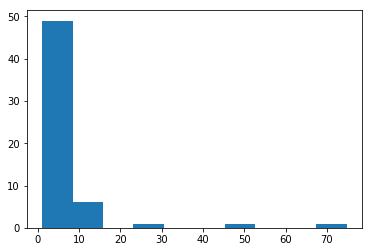

In [8]:
plt.hist(alfalfa_df.loc[alfalfa_matches, 'flux'])

In [11]:
top_ten = alfalfa_df.loc[alfalfa_matches].sort_values(by='flux')[-10:]

In [12]:
top_ten

,AGCNr,Name,HIra,HIdec,OCra,OCdec,v21,w50,werr,flux,fluxerr,snratio,rms,dist,loghimass,detcode
7374,4254,003-015,122.350418,0.611667,122.350418,0.609444,1803,156,2,7.55,0.10,44.8,3.01,28.2,9.15,1
22180,9500,DDO196,221.339584,7.864722,221.339157,7.862500,1690,24,2,9.09,0.06,143.9,2.73,27.6,9.21,1
11810,5774,N3306,159.292084,12.655833,159.292923,12.652222,2889,265,3,11.27,0.09,66.0,2.34,46.6,9.76,1
4593,1073,481-008,22.531666,25.866667,22.531250,25.863335,3674,153,2,11.46,0.08,82.1,2.52,50.1,9.83,1
4822,1230,M+405005,26.386251,25.521389,26.385416,25.520834,3837,88,2,13.93,0.06,145.4,2.27,52.2,9.95,1
3994,634,410-023,15.353333,7.629722,15.354583,7.625834,2212,138,2,14.56,0.07,117.0,2.36,26.3,9.38,1
757,12212,M+553019,342.627930,29.136667,342.625824,29.138332,894,99,2,15.60,0.07,140.2,2.48,14.5,8.89,1
17,11820,M+255015,327.373352,14.227221,327.368774,14.230833,1104,116,2,25.90,0.08,215.4,2.49,18.2,9.31,1
6163,2302,389-024,42.281666,2.129722,42.286247,2.126944,1104,52,2,50.86,0.08,501.4,3.10,14.8,9.42,1
2183,12732,476-106,355.167908,26.230556,355.165802,26.236111,747,118,2,74.77,0.10,493.7,3.11,11.6,9.38,1


## VLA Sensitivity

![sensitivity calc](sensitivity_calc.png)

## HI abundance matching and SHMF

In [52]:
nchans = 10
deltaV = 6.6
channel_flux = 8e-6  # just above confusion level
SdelV = channel_flux*nchans*deltaV

In [59]:
# more conservative
nchans = 6  # full width ~ 36 km/s
deltaV = 6.6
channel_flux = 4e-5  # 5 times confusion level
SdelV = channel_flux*nchans*deltaV

In [60]:
# parameters from https://arxiv.org/abs/1608.00007
M10 = 4.58*10**11
N10 = 9.89*10**-3
b10 = 0.9
y10 = 0.74

In [61]:
# parameters from Dooley+2016 and Dooley+2017 -- using Brook model (http://adsabs.harvard.edu/abs/2014ApJ...784L..14B)
alpha = 1.88
K0 = 0.00282

In [65]:
#distance = 30  # Mpc
distance = top_ten['dist']
min_HI_mass = 2.36e+5 * distance**2 * SdelV

for min_mass, halo_mass in zip(min_HI_mass, top_ten['loghimass']):
    # first compute halo mass for minimum HI mass
    M = Symbol('M')
    abundance_func = 2*N10*M*((M/M10)**-b10 * (M/M10)**y10)**-1 - min_mass
    min_subhalo_mass = solve(abundance_func, M)[0]
        
    # now compute halo mass for central gal
    MHI = 10**halo_mass
    M = Symbol('M')
    abundance_func = 2*N10*M*((M/M10)**-b10 * (M/M10)**y10)**-1 - MHI
    Mhost = solve(abundance_func, M)[0]
        
    # now compute N subhalos between min and halo mass
    # from Dooley+2016 (see above)
    
    Nsubhalos = K0*Mhost/(alpha - 1) * (min_subhalo_mass**(1 - alpha) - Mhost**(1 - alpha))
    
    output_string = "Min MHI: {:.2e}, min subhalo mass: {:.2e}, central MHI: {:.2e}"
    output_string += ", central halo mass: {:.2e}, {:0.1f} subhalos"
    
    print(output_string.format(min_mass, min_subhalo_mass, MHI, Mhost, Nsubhalos))

    

Min MHI: 2.973e+05, min subhalo mass: 6.243e+7, central MHI: 1.413e+09, central halo mass: 9.228e+10, 40.8 subhalos
Min MHI: 2.848e+05, min subhalo mass: 6.016e+7, central MHI: 1.622e+09, central halo mass: 1.039e+11, 47.4 subhalos
Min MHI: 8.118e+05, min subhalo mass: 1.484e+8, central MHI: 5.754e+09, central halo mass: 3.097e+11, 63.9 subhalos
Min MHI: 9.383e+05, min subhalo mass: 1.682e+8, central MHI: 6.761e+09, central halo mass: 3.559e+11, 65.8 subhalos
Min MHI: 1.019e+06, min subhalo mass: 1.805e+8, central MHI: 8.913e+09, central halo mass: 4.516e+11, 78.4 subhalos
Min MHI: 2.586e+05, min subhalo mass: 5.536e+7, central MHI: 2.399e+09, central halo mass: 1.457e+11, 71.6 subhalos
Min MHI: 7.860e+04, min subhalo mass: 1.983e+7, central MHI: 7.762e+08, central halo mass: 5.508e+10, 66.8 subhalos
Min MHI: 1.238e+05, min subhalo mass: 2.934e+7, central MHI: 2.042e+09, central halo mass: 1.268e+11, 108.9 subhalos
Min MHI: 8.188e+04, min subhalo mass: 2.054e+7, central MHI: 2.630e+09,